# Walmart: Sales in Stormy Weather

https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/

### Решение задачи предсказания осадков на основе остальных погодных данных

Описание формата погодных данных: 
https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/download/noaa_weather_qclcd_documentation.pdf

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline

import numpy as np

In [66]:
import scipy.stats

In [11]:
import seaborn.apionly as sns
plt.style.use('ggplot')
% matplotlib inline

In [3]:
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.tree
import sklearn.linear_model

Загружаем погодные данные

In [4]:
weather_df = pd.read_csv('data\\weather_df.csv.gz',index_col=0)

In [19]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,NaN,36,40,23,0,-,-,RA FZFG BR,NaN,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0,0.00,29.95,30.47,14.0,36,13.8


In [5]:
weather_columns = weather_df.columns.drop(['station_nbr','date','sunrise', 'sunset', 'codesum','snowfall','preciptotal'])
#                            .drop(['tavg','wetbulb'])
weather_columns

Index(['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

Смотрим зависимости (корреляцию) между различными погодными факторами

In [76]:
len(weather_df[::10]), len(weather_df[weather_df.preciptotal!=0][::3]), len(weather_df[weather_df.preciptotal>1])

(2052, 2066, 526)

C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


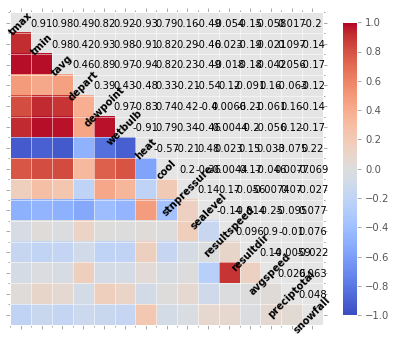

In [44]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.corrplot(weather_df[list(weather_columns)+['preciptotal','snowfall']][::10])

Из рисунка видно, что есть группа погодных факторов (`tmax`, `tmin`, `dewpoint`, `wetbulb`, `heat`, `cool`, в меньшей степени $-$ `depart`, `stnpressure`, `sealevel`), обладающих высокой (коэф. корреляции от 0.98 до 0.5) взаимной корреляцией или антикорреляцией.

Отдельно наблюдается высокая корреляция ($r$ = 0.9) между `resultspeed` и `avgspeed`.

Корреляция (антикорреляция) величины осадков (`preciptotal` и `snowfall`) с остальными погодными факторами очень низка и по модулю не превышает 0.25.

Зависимость между различными погодными факторами для случая ненулевых осадков (`preciptotal!=0`)

C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


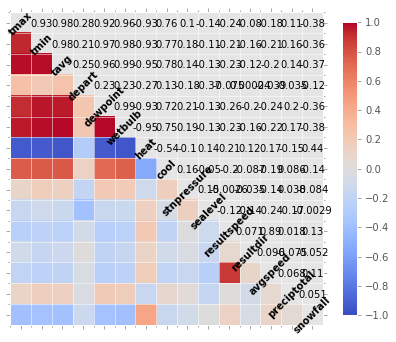

In [47]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.corrplot(weather_df[list(weather_columns)+['preciptotal','snowfall']][weather_df.preciptotal!=0][::3])

Для случая ненулевых осадков проявляются все те же самые корреляции, но гораздо лучше. 

Проявляются достаточно существенные зависимости ($r$ = 0.35-0.45) значений `preciptotal` и `snowfall` с, по крайней мере, 5-6 другими переменными.

Зависимость между различными погодными факторами для случая величины осадков, превышающей 1 дюйм (`preciptotal>1`)

C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\seaborn-0.7.0-py3.5.egg\seaborn\linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


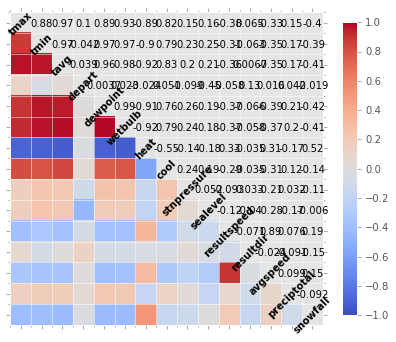

In [77]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.corrplot(weather_df[list(weather_columns)+['preciptotal','snowfall']][weather_df.preciptotal>1])

Интересно, что в данном случае корреляция между некоторыми признаками (погодными факторами) даже поменяла знак.

Визуализируем зависимости между величиной осадков `preciptotal` и другими погодными факторами для случая ненулевых осадков (`preciptotal!=0`)

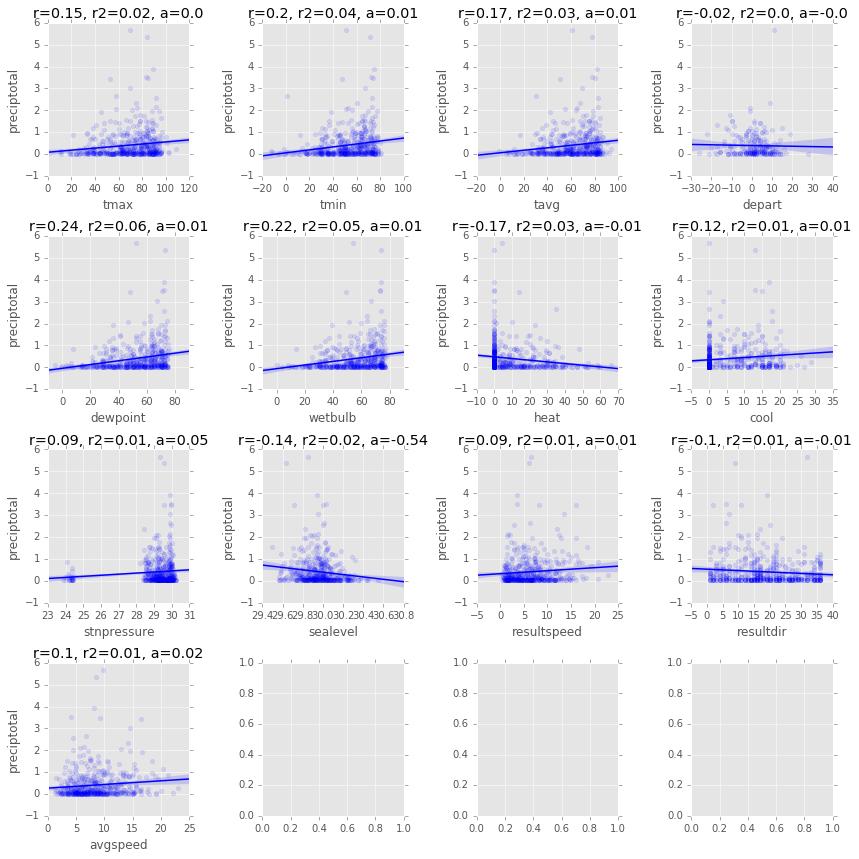

In [74]:
num=np.int(np.ceil(np.sqrt(len(weather_columns))))
fig,ax = plt.subplots(num, num, figsize=(num*3,num*3))

for i,col in enumerate(weather_columns):
    data_=weather_df[weather_df.preciptotal!=0][::10]
    #r = np.corrcoef(data_[col],data_['preciptotal'])
    #slope = np.slope(data_[col],data_['preciptotal'])
    #slope = np.linalg.lstsq(data_[col],data_['preciptotal'])[0]
    
    slope, _, r, _, _ = scipy.stats.linregress(data_[[col,'preciptotal']].dropna())

    #weather_df[::10].plot(col,'preciptotal', marker='o',linestyle='',ax=ax.flatten()[i],alpha=0.5,legend=False)
    sns.regplot(x=col,y='preciptotal',data=data_,color='b',
                ax=ax.flatten()[i],scatter_kws={'alpha':0.1})
    ax.flatten()[i].set_title('r='+str(np.round(r,2))+
                              ', r2='+str(np.round(r**2,2))+
                              ', a='+str(np.round(slope,2)))
    
plt.tight_layout()



Визуализируем зависимости между величиной осадков `preciptotal` и другими погодными факторами для случая количества осадков, превышающего 1 дюйм (`preciptotal>1`)

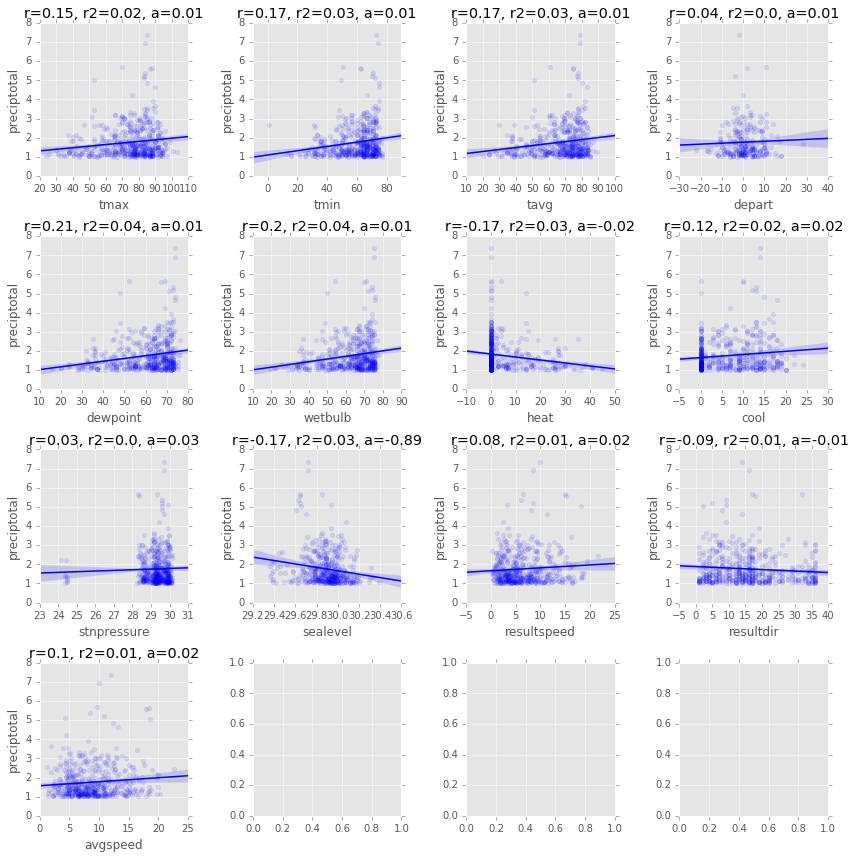

In [75]:
num=np.int(np.ceil(np.sqrt(len(weather_columns))))
fig,ax = plt.subplots(num, num, figsize=(num*3,num*3))

for i,col in enumerate(weather_columns):
    data_=weather_df[weather_df.preciptotal>1]
    slope, _, r, _, _ = scipy.stats.linregress(data_[[col,'preciptotal']].dropna())
    sns.regplot(x=col,y='preciptotal',data=data_,color='b',
                ax=ax.flatten()[i],scatter_kws={'alpha':0.1})
    ax.flatten()[i].set_title('r='+str(np.round(r,2))+
                              ', r2='+str(np.round(r**2,2))+
                              ', a='+str(np.round(slope,2)))
    
plt.tight_layout()

Из рисунков можно сделать вывод, что существует несколько переменных, показывающих корреляцию с целевой переменной (величиной осадков `preciptotal`). Однако линейные зависимости очень слабы, коэффициент детерминации $R^2$ не превышает 0.06.

Рассмотрим возможность введения разностных признаков. Создадим новые переменные, являющиеся попарными разностями существующих погодных факторов.

In [160]:
weather2_df = weather_df.copy()

for i,col1 in enumerate(weather_columns):
    for j in range(i,len(weather_columns)):
        if i!=j:
            col2=weather_columns[j]
            std_col1 = (weather_df[col1] - weather_df[col1].mean()) / weather_df[col1].std()
            std_col2 = (weather_df[col2] - weather_df[col2].mean()) / weather_df[col2].std()
            weather2_df[col1+'-'+col2] = std_col1 - std_col2
    

In [161]:
#weather2_df.info()

In [162]:
weather2_columns = weather2_df.columns.drop(['station_nbr','date','sunrise', 'sunset', 'codesum','snowfall','preciptotal'])
#weather2_columns

Рассчитаем коэффициент корреляции между новыми признаками и целевой переменной

In [163]:
cor_list = []
data_ = weather2_df[weather2_df.preciptotal!=0].dropna()
for i,col in enumerate(weather2_columns):
    cor = np.corrcoef(data_[col], data_.preciptotal)[0,1]
    cor_list.append([cor, col])
    if i%10==0: print(i,end='  ')

0  10  20  30  40  50  60  70  80  90  

In [164]:
cor_df = pd.DataFrame(cor_list,columns=['cor','name'])

cor_df['abs_cor'] = np.abs(cor_df.cor)
cor_df.sort_values(by='abs_cor',ascending=False)[['name','cor']]

,name,cor
59,dewpoint-sealevel,0.237042
38,tavg-wetbulb,-0.231012
58,dewpoint-stnpressure,0.228005
66,wetbulb-sealevel,0.219453
32,tmin-sealevel,0.212938
4,dewpoint,0.206115
17,tmax-wetbulb,-0.204466
65,wetbulb-stnpressure,0.199274
42,tavg-sealevel,0.196293
37,tavg-dewpoint,-0.194062


Для разностных признаков корреляция немного повысилась. Наибольшее значение $r$ для оригинальной переменной (`dewpoint`) $-$ 0.206, для разностной (`dewpoint-sealevel`) $-$ 0.237.

In [165]:
diff_features = cor_df.sort_values(by='abs_cor',ascending=False)['name'][:16].values
diff_features

array(['dewpoint-sealevel', 'tavg-wetbulb', 'dewpoint-stnpressure',
       'wetbulb-sealevel', 'tmin-sealevel', 'dewpoint', 'tmax-wetbulb',
       'wetbulb-stnpressure', 'tavg-sealevel', 'tavg-dewpoint',
       'tmax-dewpoint', 'depart-dewpoint', 'tmin-stnpressure',
       'dewpoint-resultdir', 'dewpoint-heat', 'tmax-sealevel'], dtype=object)

In [176]:
diff_columns = weather2_df.drop(['station_nbr','date','sunrise', 'sunset', 'codesum','snowfall','preciptotal'],axis=1).columns
len(diff_columns)

91

Рассмотрим возможность введения новых признаков, являющихся отношениями оригинальных погодных факторов.

In [133]:
weather2_df = weather_df.copy()

for i,col1 in enumerate(weather_columns):
    for j,col2 in enumerate(weather_columns):
        if i!=j:
            std_col1 = (weather_df[col1] - weather_df[col1].mean()) / weather_df[col1].std()
            std_col2 = (weather_df[col2] - weather_df[col2].mean()) / weather_df[col2].std()
            weather2_df[col1+'/'+col2] = std_col1/std_col2

In [134]:
weather2_columns = weather2_df.columns.drop(['station_nbr','date','sunrise', 'sunset', 'codesum','snowfall','preciptotal'])
len(weather2_columns)

169

In [147]:
cor_list3 = []
data_ = weather2_df[weather2_df.preciptotal!=0].dropna()
for i,col in enumerate(weather2_columns):
    cor = np.corrcoef(data_[col], data_.preciptotal)[0,1]
    cor_list3.append([cor, col])
    if i%10==0: print(i,end='  ')

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  

In [148]:
cor_df = pd.DataFrame(cor_list3,columns=['cor','name'])

cor_df['abs_cor'] = np.abs(cor_df.cor)
cor_df.sort_values(by='abs_cor',ascending=False)[['name','cor']]

,name,cor
4,dewpoint,0.206115
5,wetbulb,0.178326
1,tmin,0.165380
9,sealevel,-0.160608
6,heat,-0.153567
2,tavg,0.142805
0,tmax,0.117888
11,resultdir,-0.089871
65,dewpoint/wetbulb,0.081914
147,resultdir/tavg,-0.081771


Введение признаков-отношений не позволило получить б**о**льших корреляций с целевой переменной. Наибольшее значение $r$ было получено для переменной `dewpoint/wetbulb` и составило 0.08.

Рассмотрим 16 лучших (по критерию корреляции с целевой переменной) новых признаков

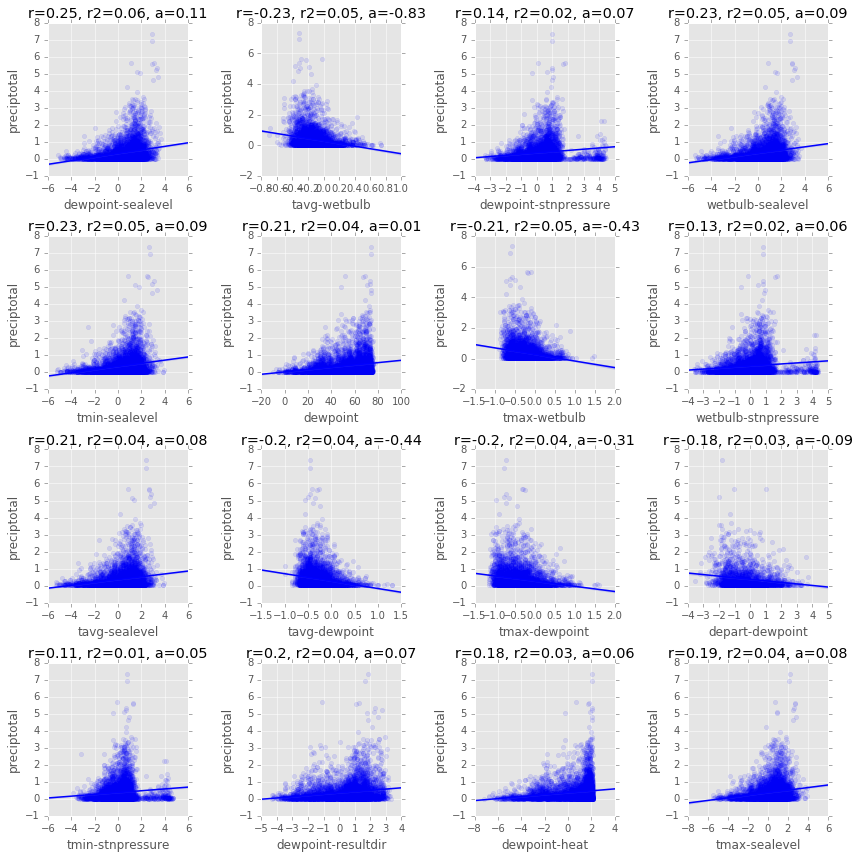

In [167]:
num=np.int(np.ceil(np.sqrt(len(diff_features))))
fig,ax = plt.subplots(num, num, figsize=(num*3,num*3))

for i,col in enumerate(diff_features):
    data_=weather2_df[weather2_df.preciptotal!=0]
    slope, _, r, _, _ = scipy.stats.linregress(data_[[col,'preciptotal']].dropna())
    sns.regplot(x=col,y='preciptotal',data=data_,color='b',
                ax=ax.flatten()[i],scatter_kws={'alpha':0.1})
    ax.flatten()[i].set_title('r='+str(np.round(r,2))+
                              ', r2='+str(np.round(r**2,2))+
                              ', a='+str(np.round(slope,2)))
plt.tight_layout()

Визуально новые признаки действительно показывают лучшую линейную зависимость с величиной осадков (`preciptotal`). Однако, по крайней мере часть из них, могут оказаться взаимно-коррелированными.

In [451]:
len(weather_df)

20517

In [456]:
len(weather_df[~weather_df.preciptotal.isnull()])

19657

Решаем задачу предсказания величины осадков на основе анализа других погодных факторов

In [501]:
features_df = weather_df[~weather_df.preciptotal.isnull()][weather_columns]#[weather_df.preciptotal>0]
target1_df = weather_df[~weather_df.preciptotal.isnull()]['preciptotal']#[weather_df.preciptotal>0]
#target2_df = weather_df[~weather_df.preciptotal.isnull()]['snowfall']#[weather_df.preciptotal>0]

#features_df = weather2_df.dropna()[diff_columns][weather2_df.preciptotal>1]
#features_df = weather2_df.dropna()[best_ten_features][weather2_df.preciptotal>1]
#target1_df = weather2_df.dropna()['preciptotal'][weather2_df.preciptotal>1]
#target2_df = weather2_df.dropna()['snowfall'][weather2_df.preciptotal>1]

In [497]:
#list(weather_columns)+['preciptotal','snowfall']

In [498]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(features_df, target1_df, test_size=0.33, random_state=42)
#y2_train, y2_test = sklearn.cross_validation.train_test_split(target2_df, test_size=0.33, random_state=42)

In [499]:
[*map(np.shape, [X_train, X_test, y_train, y_test])]#, y2_train, y2_test])]

[(13746, 13), (6771, 13), (13746,), (6771,)]

Заполняем нечисловые (отсутствующие, пропущенные) значения в данных. В данном случае используем заполнение таких ячеек наиболее часто встречающимися в выборке значениями, но можно использовать и другие подходы.

In [488]:
imputer = sklearn.preprocessing.Imputer(strategy='most_frequent')

In [489]:
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [500]:
for x in [X_train, X_test, y_train, y_test, y2_train, y2_test]:
    print( np.any(np.isnan(x)) )

True
True
True
True
True
True


Создаём полиномиальные и перекрестные признаки.

In [491]:
polfit = sklearn.preprocessing.PolynomialFeatures(2, interaction_only=True)

In [492]:
X_train_poly = polfit.fit_transform(X_train)
X_test_poly = polfit.transform(X_test)

In [493]:
[*map(np.shape, [X_train_poly, X_test_poly, y_train, y_test, y2_train, y2_test])]

[(13170, 92), (6487, 92), (13170,), (6487,), (13746,), (6771,)]

Применяем алгоритмы машинного обучения из библиотеки SciKitLearn для оценки величины целевой переменной на тестовой выборке (задача регрессии) на основе тренировки (обучения) алгоритма на данных обучающей выборки. 

В данном случае используется алгоритм RandomForestRegressor (композиционный (ensemble) алгоритм регрессии на основе случайного леса решающих деревьев).

In [495]:
data = [['data1', X_train,      y_train,  X_test,      y_test],
        #['data2', X_train,      y2_train, X_test,      y2_test],
        ['poly1', X_train_poly, y_train,  X_test_poly, y_test]]
        #['poly2', X_train_poly, y2_train, X_test_poly, y2_test]]


for [_name, _X_train, _y_train, _X_test, _y_test] in data:
    #regressor = sklearn.tree.DecisionTreeRegressor(random_state=42)
    regressor = sklearn.ensemble.RandomForestRegressor(random_state=42)
    #regressor = sklearn.linear_model.
    regressor.fit(_X_train, _y_train)
    score = regressor.score(_X_test, _y_test)
    print(_name, str(score))
    

data1 0.225095707639
poly1 0.158363260952


Тестирование на тестовой выборке показало значение $R^2$, являющееся метрикой качества предсказания в данном случае, от 0.16 до 0.23 для разного набора признаков (включая и не включая перекрёстные признаки). 

Это оказалось значительно лучше, чем значение $R^2$=0.06, которое получалось выше для одного единственного наилучшего предиктора (`dewpoint-sealevel`).

In [427]:
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)

In [228]:
np.shape(y_test)

(174, 10)

Оцениваем наиболее важные признаки, которые выделил алгоритм случайного леса.

In [393]:
feat_importance = []
for i,a in enumerate(regressor.feature_importances_):
    feat_importance.append([weather_columns[i].ljust(12),a])

In [394]:
feat_importance_df = pd.DataFrame(feat_importance, columns=['name','importan'])
feat_importance_df.sort_values(by='importan', ascending=False)

,name,importan
4,dewpoint,0.167619
0,tmax,0.125866
11,resultdir,0.113683
3,depart,0.110014
9,sealevel,0.107937
8,stnpressure,0.080542
10,resultspeed,0.067502
12,avgspeed,0.064118
2,tavg,0.057977
1,tmin,0.038474


In [205]:
best_ten_features=feat_importance_df.sort_values(by='importan', ascending=False)['name'][:10].apply(str).apply(str.strip).values
best_ten_features

array(['heat', 'heat-cool', 'tavg-heat', 'wetbulb-resultdir',
       'tavg-resultdir', 'tavg', 'tmax-resultdir', 'tmin-resultdir',
       'resultdir', 'wetbulb-heat'], dtype=object)

**Выводы:**

В данном документе мы просмотрели зависимости различных погодных факторов между собой и относительно количества осадков `preciptotal` (выбранного в данном случае в качестве целевой переменной).

Между различными погодными факторами обнаружены существенные корреляции ($r$ = 0.5-0.9). Некоторые из переменных группируются по этому признаку в отдельные кластеры. В связи с этим выглядит рационально объединять их в несколько общих предикторов с помощью алгоритмов понижения размерности данных, например, с помощью Principal Component Analysis. Такой подход должен позволить получать лучшие результаты предсказания с использованием линейных методов (например, Linear Regression, или Ridge Regression и Lasso Regression для алгоритмов с регуляризацией), чувствительных к наличию в данных коррелирующих взаимозависимых предикторов.

Рассмотрено три варианта создания дополнительных признаков на основе оригинальных - разностные признаки, признаки-отношения и перекрёстные/полиномиальные признаки. Существенного улучшения предсказательной способности отдельных признаков удалось добиться с использованием именно разностных признаков. Именно такое их преобразование позволяет лучше выделить (сделать более линейно разделимыми) данные, в которых есть хорошая зависимость с целевой переменной.

Получена лучшая корреляция погодных факторов с данными для случая ненулевых осадков (`preciptotal`>0). Это означает, что, основываясь на доступных погодных характеристиках, такие осадки предсказывать легче. Возможно, задачу удалось бы решать лучше, разделив на две: задачу классификации (должны быть осадки или их в данном случае быть не должно), а затем задачу регрессии (если осадки должны быть, то какова должна быть их величина).

В целом задача предсказания величины осадков на основе других погодных характеристик, является не простой, так как, в первую очередь, само значение этой величины (если оно не нулевое) носит в основном случайный характер. Тем не менее, применение алгоритмов машинного обучения позволило повысить оценку коэффициента детерминации $R^2$, характеризующего качество предсказания, которое даёт предсказательная модель, с 0.06 при анализе лишь одного лучшего предиктора до примерно 0.2 с использованием композиционного метода Random Forest Regression (метод регрессии с помощью случайного леса - композиции алгоритмов, представляющих собой решающие деревья).
